In [1]:
# First we initialize the model we want to use.
from langchain_openai import ChatOpenAI
import dotenv
import os
# from tools.searchTool_new import search_tool_new
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from tools.searchTool_new import search_tool_new
from langchain_core.tools import tool
store = {}

def new_agent_chat():
        
    dotenv.load_dotenv('.env')
    api_key = os.getenv("API_KEY_OPENAI")
    os.environ["OPENAI_API_KEY"] = api_key
    model = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0)
    tools = [search_tool_new]

    memory = InMemorySaver()

    # Define the graphh
    agent = create_react_agent(model,tools=tools,checkpointer=memory)
        
    return agent



In [2]:
# First we initialize the model we want to use.
from langchain_openai import ChatOpenAI
import dotenv
import os
# from tools.searchTool_new import search_tool_new
from langgraph.prebuilt import create_react_agent
from tools.searchTool_new import search_tool_new
#RunnableWithMessageHistory is used to keep track of the chat history
from langchain_core.prompts import PromptTemplate


store = {}

def new_agent_portfolio():
    
    dotenv.load_dotenv('.env')
    api_key = os.getenv("API_KEY_OPENAI")
    os.environ["OPENAI_API_KEY"] = api_key
    model = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0)
    tools = [search_tool_new]


    prompt_portfolio_simple = (
        """
    You are a financial assistant. Your job is to analyze recent financial news and propose a new investment portfolio distribution.

    Instructions:
    - Begin your response **immediately** with a Python dictionary. Do not include any introductory text.
    - The dictionary cannot be equivalent to the previous portfolio. It must be a new distribution.
    - All values must be strings representing percentages with a `%` sign (e.g., "25%").
    - The **total of all allocations, including "Cash Reserve", must sum to exactly 100%**.
    - Ensure numerical precision. The sum must be **mathematically correct** — not approximated or rounded in a way that causes drift.
    - After the dictionary, include a brief explanation of your reasoning, separated by `$$`.

    Output format:
    {{
        "Asset 1": "XX%",
        "Asset 2": "YY%",
        "Cash Reserve": "ZZ%",
        ...
    }}$$
    (Brief explanation: summarize your reasoning based on current market conditions.)
    """
    )


    #Define the graphh
    agent = create_react_agent(model,tools=tools,prompt=prompt_portfolio_simple)
    
    
    return agent



In [3]:

AGENTS = {}

In [4]:
#used for registering agents because it must be initialized after the FAISS index is created or loaded
AGENTS = {}

In [5]:
from langchain_core.messages import SystemMessage

def nodo_1_generar_portafolio_inicial(state: dict = None) -> dict:
    """
    Node 1: Welcome message and initial portfolio generation.
    """
    welcome_message = (
        "Welcome to the investment portfolio assistant! "
        "I will help you create a personalized investment portfolio. "
    )

    print(welcome_message)
    print("\n")

    return{
        **state,
        'portfolio_history': [],
        "messages": [SystemMessage(content=welcome_message)]
        
    }


In [6]:

from langchain_core.messages import HumanMessage, SystemMessage
from utils.index_news import index_news
from utils.get_news import get_news
def nodo_2_indexar_noticias(state: dict) -> dict:

    """
    Node 2: Indexing news articles.
    """

    tickers = list(state["portfolio"].keys())[:-1]  # Get the tickers from the portfolio
    # Check if the news data is already indexed
    # then index the news data
    news_data = get_news(tickers, from_days=20)
    print("news_data", news_data)
    index_news(news=news_data)

    return {
        **state,
        'portfolio_history': [],
        "messages": [SystemMessage(content="Noticias indexadas exitosamente. Puedes revisar el portafolio o buscar información adicional.")],

        "next_action": "",  # next_action indica siguiente paso
    }


In [7]:
def nodo_3_pedir_accion_usuario(state: dict) -> dict:
    """
    Node 3: Ask the user for the next action.
    This node prompts the user to choose an action from a list of options.
    Depending on the user's choice, it will return the corresponding action.
    If the user chooses to exit, it will return an exit action.
    """

    mensaje = (
        "What would you like to do next?\n"
        "1. Update news\n"
        "2. Ask questions\n"
        "3. Rebalance portfolio\n"
        "4. Exit\n"
        "Please enter the number or the action name (e.g., 'update news', 'ask questions', 'rebalance portfolio', 'exit').\n"
        )
        

    
    while 1:
        user_action = str(input(mensaje))

        if user_action == "1" or user_action.lower() == "actualizar noticias" or user_action == "update news":
            action = "actualizar noticias"
            break
        elif user_action == "2" or user_action.lower() == "conversar" or user_action == "ask questions":
            action = "hacer preguntas"
            break
        elif user_action == "3" or user_action.lower() == " rebalancear portafolio" or user_action == "rebalance portfolio":
            action = "sugerir rebalanceo"
            break
        elif user_action.lower() == "salir" or user_action.lower() == "exit" or user_action == "4":
            action = "salir"
            break
        else:
            action = None
            print("Invalid action. Please try again.")
            
        # print("action", action)
    return {
        **state,
        'portfolio_history': [],
        "messages":[],
        "next_action": action,  # next_action indica siguiente paso
    }

In [8]:

from core.agent_registry import AGENTS
from langgraph.checkpoint.memory import InMemorySaver


# Nodo de conversación
def nodo_4_responder_dudas(state: dict) -> dict:
    """
    Node 4: Respond to user questions.
    This node allows the user to ask questions and receive answers from the agent.
    It uses the agent_chat to handle the conversation.
    """

    # Check if the agent is initialized
    agent_chat = AGENTS["new_agent_chat"]  
    while 1:
        msg = str(input("Type 'options' or 'o' to go back | Type portfolio to see your portfolio and news about your portfolio | Or type your question: "))

        if msg.lower() in ["options","opciones","o"]:
            break

        elif msg.lower() == "portfolio":
            print("Your portfolio is: ", state["portfolio"])
            res = agent_chat.invoke(
                {'messages': f'news related to my portfolio: {state["portfolio"]}'}, 
                {'configurable': {'thread_id': '111'}}
            )    
            print("News about your portfolio: ", res['messages'][-1].content)
            continue

        else:
            res = agent_chat.invoke(
                # {'messages': [msg],}, 
                {'configurable': {'thread_id': '111'}}
            )    
            print()
            print(res['messages'][-1].content)
            print()

    return {
        **state,
        'portfolio_history': [],
        "next_action": "opciones"
    }


In [9]:
import ast
from core.agent_registry import AGENTS
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

def nodo_5_rebalanceo_recomendado(state: dict) -> dict:
    """
    Node 5: Rebalance recommended portfolio.
    This node suggests rebalancing the portfolio based on news and user input.
    It uses the agent_portfolio to analyze the news and provide recommendations.
    The user is then prompted to confirm whether they want to rebalance the portfolio or not.
    """

    # old and new agent portfolio

    # agent_portfolio = state["agent_portfolio"]  # Obtener el agente executor
    agent_portfolio = AGENTS["new_agent_portfolio"]  # Obtener el agente executor
    result = agent_portfolio.invoke({'messages' : "analyze the news to rebalance my investment portfolio" + str(state["portfolio"])})


    print("Recomended Portfolio:")
    print(result["messages"][-1].content)
    extract_portfolio = (result["messages"][-1].content).split('$$')[0].strip().replace("%", "")
    new_portfolio = ast.literal_eval(extract_portfolio[extract_portfolio.index('{'):])
    reason = result["messages"][-1].content.split('$$')[1].strip()

    to_output = []
    to_output.append(HumanMessage(content="Rebalance my portfolio based on news:"))
    to_output.append(AIMessage(content='Your New Portfolio: ' + str(agent_portfolio)))


    #convert values from string to float to check if the sum is 100%
    for key in new_portfolio.keys():
        new_portfolio[key] = float(new_portfolio[key])
    
    #quality check to see if the sum of the portfolio is 100%
    if sum(new_portfolio.values()) != 100:
        print("La suma de los porcentajes no es igual a 100%. Intenta de nuevo.")
        return {
            **state,
            "messages": [],
            "portfolio_history": [],
            "next_action": "rechazar",
        }
    
    inital_usd = 10000  # initial investment in USD

    #split the money in the portfolio to see how much money is in each stock
    for key in new_portfolio.keys():
        new_portfolio[key] = round((inital_usd * new_portfolio[key]) / 100, 2)


    print('Nuevo portafolio:\n', new_portfolio)
    print('--'*50)
    print('Razón:\n', reason)
    # print()

    #user input to confirm rebalance
    input_message = input("Do you want to rebalance your portfolio? (yes/no): ")
    # if user input is yes, rebalance the portfolio and return the new state
    if input_message.lower() == "yes" or input_message.lower() == "y" or input_message.lower() == "si":
        print("Rebalancing portfolio...")
        return {
            **state,
            "messages": [to_output],
            "portfolio": new_portfolio,
            "portfolio_history": [([new_portfolio],reason)],
            "next_action": "aplicar",
        }

    #if user input is no, do not rebalance and return to the previous state
    elif input_message.lower() == "no" or input_message.lower() == "n":
        print("No change will be made to the portfolio.")
        return {
            **state,
            "messages": [],
            'portfolio_history': [],
            "next_action": "rechazar",
        }

    else:
        print("Invalid input. Please enter 'yes' or 'no'.")
        return {
            **state,
            'portfolio_history': [],
            "messages": [],
            "next_action": "rechazar",
    }

In [10]:

from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
import os

import dotenv

@tool
def search_tool_new(query: str) -> str:
    """Use this to get context information about finantial news."""
    #LOAD ENVIRONMENT VARIABLES
    dotenv.load_dotenv('../.env')
    api_key = os.getenv("API_KEY_OPENAI")
    os.environ["OPENAI_API_KEY"] = api_key
    # Load the vectorstore as a search tool to search for news articles distantly related to the query.
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")  # o "text-embedding-ada-002"
    # Load the FAISS index from the local directory (basically db embeddings)
    db = FAISS.load_local("./data/faiss_news_index/", embeddings=embeddings, allow_dangerous_deserialization=True)
    # Create a retriever from the vectorstore
    retriever = db.as_retriever()
    # Use the retriever to search for relevant documents based on the query
    docs = retriever.invoke(query,k=7)
    #return with metadata and content of the documents
    return "\n\n".join([
        f"Título: {doc.metadata.get('title', 'N/A')}\n"
        f"Fuente: {doc.metadata.get('source', 'N/A')}\n"
        f"URL: {doc.metadata.get('url', 'N/A')}\n"
        f"Contenido: {doc.page_content}"
        for doc in docs
    ])


In [11]:
from langchain_openai import OpenAIEmbeddings
import dotenv
import os
from langchain_community.vectorstores import FAISS
from langchain.tools import Tool


####NOT IN USE OLD VERSION####

def buscar_contexto(query: str) -> str:
    dotenv.load_dotenv('../.env')
    api_key = os.getenv("API_KEY_OPENAI")
    os.environ["OPENAI_API_KEY"] = api_key
    # Paso 1: Configurar el vectorstore como herramienta de búsqueda
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")  # o "text-embedding-ada-002"
    db = FAISS.load_local("./data/faiss_news_index/", embeddings=embeddings, allow_dangerous_deserialization=True)
    retriever = db.as_retriever()
    docs = retriever.invoke(query,k=15)
    return "\n\n".join([
        f"Título: {doc.metadata.get('title', 'N/A')}\n"
        f"Fuente: {doc.metadata.get('source', 'N/A')}\n"
        f"URL: {doc.metadata.get('url', 'N/A')}\n"
        f"Contenido: {doc.page_content}"
        for doc in docs
    ])

def search_tool():
    herramienta_busqueda = Tool(
        name="SearchNews",
        func=buscar_contexto,
        description="useful for searching news articles and financial information. "
    )
    return herramienta_busqueda

In [12]:
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import re
import dotenv
import os

def limpiar_contenido(texto: str) -> str:
    """
    Clean the extracted content by removing unwanted elements and formatting.
    """
    texto = re.sub(r'\s+', ' ', texto)
    texto = re.sub(r'via Getty Images.*$', '', texto)
    texto = re.sub(r'^[Bb]y\s+[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\s*', '', texto)
    texto = re.sub(r'\n.{1,10}\n', '\n', texto)
    return texto.strip()


def extraer_contenido_html(html: str) -> str:
    """
    Extract the main content from the HTML of a news article. Not so clean but works for most cases.
    """
    soup = BeautifulSoup(html, 'html.parser')

    possible_selectors = [
        'article',
        'div[itemprop="articleBody"]',
        'div[class*="article"]',
        'section[class*="content"]',
        'div[class*="story"]',
        'main',
        'div[role="main"]',
        'div[class*="text"]',
    ]

    containers = soup.select(','.join(possible_selectors))
    container = max(containers, key=lambda c: len(c.find_all('p')), default=None)

    def limpiar_parrafos(parrafos):
        vistos = set()
        limpios = []
        for p in parrafos:
            texto = p.get_text().strip()
            if len(texto) >= 40 and texto not in vistos:
                limpios.append(texto)
                vistos.add(texto)
        return limpios

    if container:
        parrafos = limpiar_parrafos(container.find_all('p'))
    else:
        parrafos = limpiar_parrafos(soup.find_all('p'))

    return '\n'.join(parrafos)


def obtener_articulos(query: str, api_key: str, page_size: int, from_date: str, max_articulos: int = 10) -> list:
    """
    Fetch articles from the News API based on the query and date range.
    """
    url = (
        f"https://newsapi.org/v2/everything?q={query}"
        f"&from={from_date}&pageSize={page_size}"
        f"&sortBy=publishedAt&apiKey={api_key}"
    )

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud: {e}")
        return []

    articles = data.get("articles", [])
    resultados = []

    for article in articles:
        try:
            raw_html = requests.get(article["url"]).text
            contenido = extraer_contenido_html(raw_html)
            if contenido:
                contenido_limpio = limpiar_contenido(contenido) #[:1250]
                resultados.append({
                    "title": article.get("title"),
                    "content": contenido_limpio,
                    "source": article.get("source", {}).get("name", "Desconocido"),
                    "url": article.get("url"),
                })
                if len(resultados) >= max_articulos:
                    break
        except Exception as e:
            print(f"No se pudo procesar {article['url']}: {e}")

    print(f"Se encontraron {len(resultados)} artículos relevantes para '{query}'.")
    return resultados


def get_news(queries: list[str], page_size: int = 20, from_days: int = 7) -> list[dict]:
    """
    Fetch news articles based on the provided queries and date range.
    """

    dotenv.load_dotenv('.env')
    api_key = os.getenv("API_KEY_NEWSAPI")

    from_date = (datetime.now() - timedelta(days=from_days)).strftime("%Y-%m-%d")

    todas_las_noticias = []
    for query in queries:
        print(f"\nBuscando noticias para: '{query}' desde {from_date}...")
        noticias = obtener_articulos(query, api_key, page_size, from_date)
        todas_las_noticias.extend(noticias)

    return todas_las_noticias


In [13]:
from typing import List
from langchain_openai import OpenAIEmbeddings
import dotenv
import hashlib, os
from uuid import uuid4
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter


# This function indexes news articles using FAISS and OpenAI embeddings.
def index_news(news: List[dict], 
               path_indice: str = "./data/faiss_news_index", 
               check_dups: bool = True) -> None:
    """
    Indexes news articles using FAISS and OpenAI embeddings.
    """

    # Load environment variables from .env file
    dotenv.load_dotenv('../.env')
    api_key = os.getenv("API_KEY_OPENAI")
    
    print("Indexing news...")
    #embedding_model instance
    embedding_model = OpenAIEmbeddings(
        model="text-embedding-3-small",  
        openai_api_key=api_key,  
    )

    # The RecursiveCharacterTextSplitter is used to split the text into smaller chunks for better indexing.
    splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=40)

    def hash_text(text: str) -> str:
        """
        Hashes the text to create a unique identifier for it.
        """
        # Use MD5 hash for simplicity.
        return hashlib.md5(text.encode('utf-8')).hexdigest()

    if not news:
        # If no news articles are provided, load the existing index and return it.
        print("non relevant news")
        vectorstore = FAISS.load_local(path_indice, embedding_model, allow_dangerous_deserialization=True)
        return vectorstore


    # Extract content and metadata from the news articles.
    contents, metadatas = [], []
    for noticia in news:
        content = noticia.get("content", "") or ""
        if content.strip() == "":
            continue
        contents.append(content)
        # Extract metadata from the news article for indexing.
        metadatas.append({
            "title": noticia.get("title", ""),
            "source": noticia.get("source", ""),
            "url": noticia.get("url", ""),
        })

    print("splitting news in chunks...")
    new_docs = splitter.create_documents(contents, metadatas=metadatas)

    if not new_docs:
        print("there's not news to index")
        return

    content_existente = set()

    # Check if the index already exists.
    if os.path.exists(path_indice):
        print("loading existing FAISS index...")
        #FAISS is the vector store used for indexing the vector representation or embedding.
        vectorstore = FAISS.load_local(path_indice, embedding_model, allow_dangerous_deserialization=True)
        if check_dups:
            documentos_existentes = vectorstore.docstore._dict.values()
            content_existente = set(hash_text(doc.page_content) for doc in documentos_existentes)
    else:
        # otherwise, create a new index.
        print("Creating new FAISS index...")
        vectorstore = FAISS.from_documents(new_docs, embedding_model)

    print("Filtering duplicates...")
    if check_dups:
        docs_to_add = [doc for doc in new_docs if hash_text(doc.page_content) not in content_existente]
    else:
        docs_to_add = new_docs

    if not docs_to_add:
        print("News was already indexed. No new news to add.")
        return vectorstore

    # Generate unique IDs for the new documents.
    ids = [str(uuid4()) for _ in docs_to_add]

    print(f"adding {len(docs_to_add)} documents to the index...")
    vectorstore.add_documents(documents=docs_to_add, ids=ids)
    #save the updated index to the specified path to avoid re-processing the same data.
    vectorstore.save_local(path_indice)
    print(f"Index updated with {len(docs_to_add)} new news.")
    return vectorstore


In [14]:
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import BaseMessage
from typing import Annotated
import operator
from typing_extensions import TypedDict



# definicion de los nodos del grafo
def init_graph():
    """
    this function initializes a state graph for a financial assistant agent using the Langchain library.
    It defines the nodes and edges of the graph, representing different states and actions the agent can take during its interaction with the user.
    The graph is designed to help the agent generate an initial portfolio, index news, ask for user actions, respond to questions, and suggest rebalancing based on user input.
    """
    
    class State(TypedDict):
        portfolio: dict
        messages: Annotated[list[BaseMessage], operator.add]
        portfolio_history: Annotated[list[BaseMessage], operator.add]
        next_action: str

    # Initialize the state graph
    # The state graph is a directed graph where each node represents a state in the conversation.
    workflow = StateGraph(State)

    # Define the nodes of the graph
    # Each node is a function that represents a specific action or state in the conversation.
    # The nodes are defined in separate modules and imported here.
    # The nodes are responsible for generating the initial portfolio, indexing news, asking for user actions, responding to questions, and suggesting rebalancing.
    # The nodes are connected by edges, which represent the flow of the conversation.
    # The edges are defined using the add_edge and add_conditional_edges methods of the StateGraph class.
    # The edges are used to connect the nodes and define the flow of the conversation.
    workflow.add_node("nodo_1_generar_portafolio_inicial", nodo_1_generar_portafolio_inicial)
    workflow.add_node("nodo_2_indexar_noticias", nodo_2_indexar_noticias)
    workflow.add_node("nodo_3_pedir_accion_usuario", nodo_3_pedir_accion_usuario)
    workflow.add_node("nodo_4_responder_dudas", nodo_4_responder_dudas)
    workflow.add_node("nodo_5_rebalanceo_recomendado", nodo_5_rebalanceo_recomendado)

    # Define the edges of the graph
    # The edges are used to connect the nodes and define the flow of the conversation.
    workflow.add_edge(START, "nodo_1_generar_portafolio_inicial")
    workflow.add_edge("nodo_1_generar_portafolio_inicial", "nodo_2_indexar_noticias")
    workflow.add_edge("nodo_2_indexar_noticias", "nodo_3_pedir_accion_usuario")
    # conditional edges are used to define the flow of the conversation based on user input or other conditions.
    # The conditional edges are defined using the add_conditional_edges method of the StateGraph class.
    # The conditional edges are used to connect the nodes and define the flow of the conversation based on user input or other conditions.
    workflow.add_conditional_edges(
        "nodo_3_pedir_accion_usuario",
        lambda state: state["next_action"],  # next_action indica siguiente paso
        {
            "actualizar noticias": "nodo_2_indexar_noticias",
            "hacer preguntas": "nodo_4_responder_dudas",
            "sugerir rebalanceo": "nodo_5_rebalanceo_recomendado",
            "salir": END
        },
    )
    workflow.add_conditional_edges(
        "nodo_4_responder_dudas",
        lambda state: state["next_action"],
        {
            "hacer preguntas": "nodo_4_responder_dudas",
            "opciones": "nodo_3_pedir_accion_usuario",
        },

    )
    workflow.add_edge("nodo_5_rebalanceo_recomendado", "nodo_3_pedir_accion_usuario")

    # Define memory management for the graph
    # memory = MemorySaver()
    # The memory management is used to save and load the state of the conversation if is needed
    # for example, if the user wants to save the conversation and continue later.
    # or if you reach a sensitive point in the conversation and you want to save the state of the conversation.
    graph = workflow.compile()
    return graph


In [15]:

graph = init_graph()

In [16]:
graph


ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [17]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	nodo_1_generar_portafolio_inicial(nodo_1_generar_portafolio_inicial)
	nodo_2_indexar_noticias(nodo_2_indexar_noticias)
	nodo_3_pedir_accion_usuario(nodo_3_pedir_accion_usuario)
	nodo_4_responder_dudas(nodo_4_responder_dudas)
	nodo_5_rebalanceo_recomendado(nodo_5_rebalanceo_recomendado)
	__end__([<p>__end__</p>]):::last
	__start__ --> nodo_1_generar_portafolio_inicial;
	nodo_1_generar_portafolio_inicial --> nodo_2_indexar_noticias;
	nodo_2_indexar_noticias --> nodo_3_pedir_accion_usuario;
	nodo_5_rebalanceo_recomendado --> nodo_3_pedir_accion_usuario;
	nodo_3_pedir_accion_usuario -. &nbsp;actualizar noticias&nbsp; .-> nodo_2_indexar_noticias;
	nodo_3_pedir_accion_usuario -. &nbsp;hacer preguntas&nbsp; .-> nodo_4_responder_dudas;
	nodo_3_pedir_accion_usuario -. &nbsp;sugerir rebalanceo&nbsp; .-> nodo_5_rebalanceo_recomendado;
	nodo_3_pedir_accion_usuario -. &nbsp;salir&nbsp; .-> __end__;
	nod


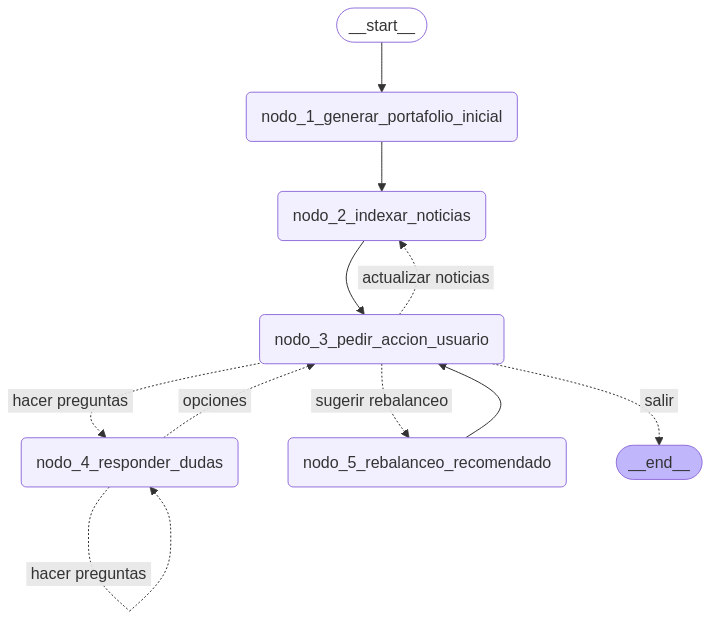